In [ ]:
pip install torch torchvision

In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
# Load the pre-trained Faster R-CNN model with a ResNet-50 backbone
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Number of classes (your dataset classes + 1 for background)
num_classes = 3  # For example, 2 classes + background

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the head of the model with a new one (for the number of classes in your dataset)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [1]:
import torch
import torchvision
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor

# Path to dataset
train_dataset = CocoDetection(
    root="apple-detection/train",  # images folder
    annFile="apple-detection/train/_annotations.coco.json",  # annotations
    transform=ToTensor()
)

val_dataset = CocoDetection(
    root="apple-detection/valid",
    annFile="apple-detection/valid/_annotations.coco.json",
    transform=ToTensor()
)

print("Training samples:", len(train_dataset))


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Training samples: 390


In [2]:
print("Validation samples:", len(val_dataset))

Validation samples: 112


In [4]:
pip install pycocotools


Note: you may need to restart the kernel to use updated packages.


In [3]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Load pre-trained Faster R-CNN
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Replace head for 2 classes (background + apple)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


In [ ]:
from torch.utils.data import DataLoader

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)), num_workers=0)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]

        # Convert targets into correct format
        new_targets = []
        for t in targets:  # each t = list of objects (annotations)
            boxes = []
            labels = []

            for obj in t:
                # COCO bbox format: [x, y, width, height]
                x, y, w, h = obj['bbox']
                boxes.append([x, y, x + w, y + h])

                # Force all labels to "apple" = class 1
                labels.append(1)

            if len(boxes) == 0:  # skip if no apples
                continue

            new_targets.append({
                "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                "labels": torch.tensor(labels, dtype=torch.int64).to(device)
            })

        if len(new_targets) == 0:  # skip batch if no valid targets
            continue

        # Forward pass
        loss_dict = model(images, new_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}")


In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim

# ----------------------------
# Dataset Class
# ----------------------------
class AppleDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, images_dir, transforms=None):
        import json, os
        self.transforms = transforms
        self.images_dir = images_dir

        with open(annotations) as f:
            coco = json.load(f)

        self.images = coco["images"]
        self.annotations = coco["annotations"]
        self.categories = coco["categories"]

        # Group annotations by image_id
        self.img_id_to_annots = {}
        for ann in self.annotations:
            self.img_id_to_annots.setdefault(ann["image_id"], []).append(ann)

    def __getitem__(self, idx):
        import os, PIL.Image as Image
        img_info = self.images[idx]
        img_path = os.path.join(self.images_dir, img_info["file_name"])
        img = Image.open(img_path).convert("RGB")

        annots = self.img_id_to_annots.get(img_info["id"], [])

        boxes, labels = [], []
        for ann in annots:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"] + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_info["id"]])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.images)


# ----------------------------
# Prepare Dataset & DataLoader
# ----------------------------
transform = torchvision.transforms.ToTensor()

train_dataset = AppleDataset("apple-detection/train/_annotations.coco.json", "apple-detection/train", transforms=transform)

# Limit dataset size for debugging
train_dataset.images = train_dataset.images[:50]

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)),
    num_workers=0
)

# ----------------------------
# Model Setup
# ----------------------------
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 5  # background + apple
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 2

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    model.train()

    for batch_idx, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f"  Batch {batch_idx+1}/{len(train_loader)} - Loss: {losses.item():.4f}")

    print(f"Epoch {epoch+1} finished ✅\n")


Using device: cpu


c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/2]
  Batch 1/25 - Loss: 15.6311
  Batch 2/25 - Loss: 3.3418
  Batch 3/25 - Loss: 0.9408
  Batch 4/25 - Loss: 1.4879
  Batch 5/25 - Loss: 1.6246
  Batch 6/25 - Loss: 1.7861
  Batch 7/25 - Loss: 25.6091
  Batch 8/25 - Loss: 1.7103
  Batch 9/25 - Loss: 1.7489
  Batch 10/25 - Loss: 1.7153
  Batch 11/25 - Loss: 8.3841
  Batch 12/25 - Loss: 1.2203
  Batch 13/25 - Loss: 21.0592
  Batch 14/25 - Loss: 0.9813
  Batch 15/25 - Loss: 7.9006
  Batch 16/25 - Loss: 2.3852
  Batch 17/25 - Loss: 6.7673
  Batch 18/25 - Loss: 1.7358
  Batch 19/25 - Loss: 1.1716
  Batch 20/25 - Loss: 6.8809
  Batch 21/25 - Loss: 1.2553
  Batch 22/25 - Loss: 1.1707
  Batch 23/25 - Loss: 0.7229
  Batch 24/25 - Loss: 1.0738
  Batch 25/25 - Loss: 1.6040
Epoch 1 finished ✅

Epoch [2/2]
  Batch 1/25 - Loss: 9.0636
  Batch 2/25 - Loss: 0.9353
  Batch 3/25 - Loss: 8.5465
  Batch 4/25 - Loss: 23.8290
  Batch 5/25 - Loss: 6.8663
  Batch 6/25 - Loss: 2.0387
  Batch 7/25 - Loss: 1.4577
  Batch 8/25 - Loss: 1.6969
  Batch 9/25

In [2]:
torch.save(model.state_dict(), "fasterrcnn_apple.pth")
print("Model saved as fasterrcnn_apple.pth")

Model saved as fasterrcnn_apple.pth


In [3]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [8]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image

# Load one test image
img_path = "apple-detection/test/app01671_jpeg.rf.a50212273f206df3966733d796ef8591.jpg"  # change to your test image path
img = Image.open(img_path).convert("RGB")

# Transform to tensor
transform = T.ToTensor()
img_tensor = transform(img).to(device)

# Run inference (no targets during inference!)
with torch.no_grad():
    prediction = model([img_tensor])

print(prediction)  # bounding boxes, labels, scores


[{'boxes': tensor([[1167.8131,  328.6513, 1224.9922,  383.0700],
        [ 325.6459,  628.1459,  355.4352,  661.7599],
        [ 651.0063,  320.0424,  705.9985,  368.0815],
        [ 988.5565,  100.1247, 1025.6681,  128.7407],
        [ 232.5123,  160.5382,  286.1880,  219.6344],
        [ 978.0986,   96.7732, 1033.1174,  137.3608],
        [ 882.8471,  936.0212,  940.8297,  983.9831],
        [1293.0743,  901.3113, 1347.4624,  936.2542],
        [ 469.2367,  418.3289,  518.4373,  455.6451],
        [1624.0559,   45.1962, 1656.6068,   93.0109],
        [1161.1055,  316.7232, 1241.2605,  395.4166],
        [ 317.1480,  167.2233,  352.0042,  215.5824],
        [1391.8925,  197.4312, 1422.2186,  218.4953],
        [1145.6597,  746.6320, 1196.5081,  799.2466],
        [ 443.4591,  126.0919,  475.4051,  162.3053],
        [ 873.0986,  294.2995,  900.4354,  338.4278],
        [1106.7871,  267.4011, 1156.0808,  312.6917],
        [1144.6759,  723.5231, 1198.6498,  826.8482],
        [1609.353

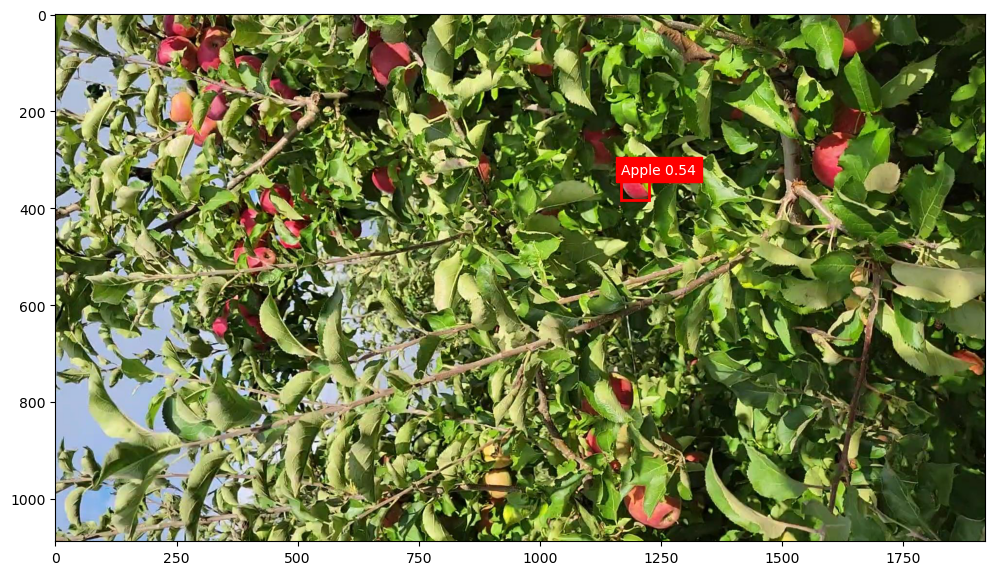

In [9]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

for box, score, label in zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels']):
    if score > 0.5:  # confidence threshold
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                                 edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f"Apple {score:.2f}", color='white', backgroundcolor='red')

plt.show()


In [12]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image

# Load one test image
img_path = "apple-detection/test/app00121_jpeg.rf.028cea0513e2420f5a00312005f13825.jpg"  # change to your test image path
img = Image.open(img_path).convert("RGB")

# Transform to tensor
transform = T.ToTensor()
img_tensor = transform(img).to(device)

# Run inference (no targets during inference!)
with torch.no_grad():
    prediction = model([img_tensor])

print(prediction)  # bounding boxes, labels, scores


[{'boxes': tensor([[1847.3685,  199.9004, 1905.5388,  248.5543],
        [1066.4739,  679.5308, 1126.3102,  740.7997],
        [ 814.4656,  676.5162,  851.7993,  728.9084],
        [ 433.5827,   76.0415,  463.5346,  105.5595],
        [1406.9198,  326.3590, 1462.0262,  376.3244],
        [ 501.0746,  719.1900,  564.0076,  786.8030],
        [ 234.6027,  839.6604,  292.2661,  894.4333],
        [1074.9478,  481.9660, 1130.1609,  532.4418],
        [ 808.0030,  686.3067,  860.8418,  740.4423],
        [ 411.3217,  895.8447,  493.7144,  981.7169],
        [ 331.4956,  856.3245,  386.9506,  900.5866],
        [ 719.7746,  992.5565,  766.4341, 1028.9612],
        [ 729.0121,  996.4029,  758.8981, 1021.9274],
        [ 419.5099,  916.5620,  477.2585,  976.6866],
        [ 426.7874,  901.7487,  483.3112,  960.3661],
        [ 219.9633,  811.6155,  302.8417,  899.2577],
        [ 424.1783,   69.3787,  472.4858,  107.4780],
        [ 742.3124,  267.6297,  768.4191,  291.8003],
        [ 256.178

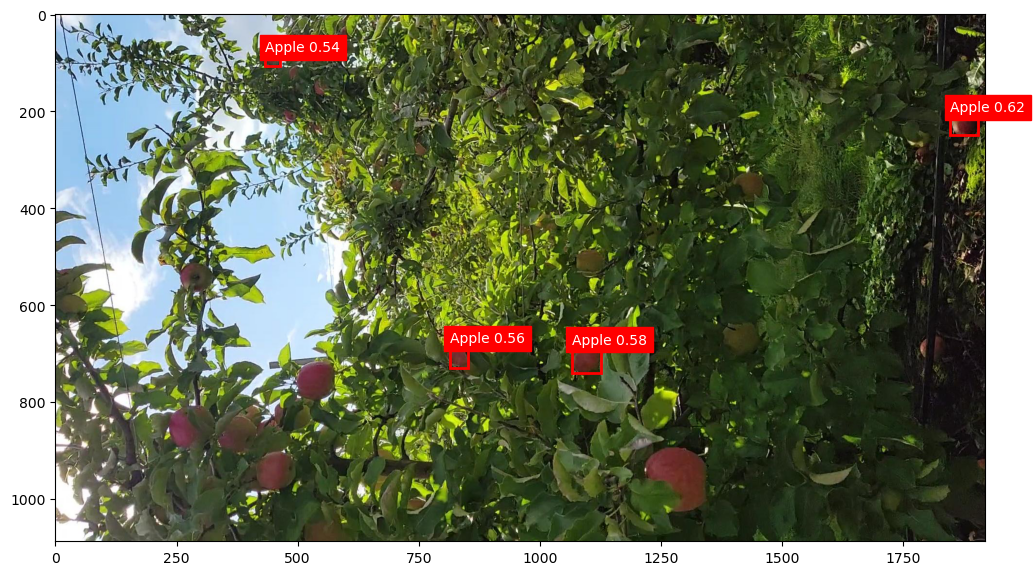

In [13]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

for box, score, label in zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels']):
    if score > 0.5:  # confidence threshold
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                                 edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f"Apple {score:.2f}", color='white', backgroundcolor='red')

plt.show()
